In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
def get_kraken_data(symbol):
    filename = 'Kraken_OHLCVT/{}USD_1.csv'.format(symbol.replace('BTC', 'XBT'))
    if not os.path.exists(filename):
        return pd.DataFrame()
    df = pd.read_csv(
        filename,
        names=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume', 'trades']
    )
    
    df['timestamp_5m'] = (df['timestamp'] // 300) * 300
    df['timestamp_1h'] = (df['timestamp'] // 3600) * 3600

    df_5m = pd.concat([
        df.groupby('timestamp_5m')['cl'].nth(-1),
    ], axis=1)
    df_5m = df_5m.reset_index()
    df_5m['timestamp_1h'] = (df_5m['timestamp_5m'] // 3600) * 3600
    
    df = pd.concat([
        df.groupby('timestamp_1h')['op'].nth(0),
        df.groupby('timestamp_1h')['hi'].max(),
        df.groupby('timestamp_1h')['lo'].min(),
        df.groupby('timestamp_1h')['cl'].nth(-1),
        df.groupby('timestamp_1h')['volume'].sum(),
        df.groupby('timestamp_1h')['trades'].sum(),
        df_5m.groupby('timestamp_1h')['cl'].mean().rename('twap_5m'),
    ], axis=1)
    
    df.index.rename('timestamp', inplace=True)
    
    df['symbol'] = symbol
    df = df.reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df = df.set_index(['timestamp', 'symbol'])
    return df

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    dfs = list(map(get_kraken_data, symbols))
    df = df.copy()
    df['extended'] = False
    df = pd.concat([df] + dfs)
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    # df = df.loc[df.index.drop_duplicates()]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()
    
display(get_kraken_data('BTC'))

,,op,hi,lo,cl,volume,trades,twap_5m
timestamp,symbol,,,,,,,
2013-10-06 21:00:00+00:00,BTC,122.00000,122.00000,122.00,122.00,0.100000,1,122.000000
2013-10-07 20:00:00+00:00,BTC,123.61000,123.61000,123.61,123.61,0.100000,1,123.610000
2013-10-08 02:00:00+00:00,BTC,123.91000,123.91000,123.90,123.90,1.991600,2,123.900000
2013-10-08 05:00:00+00:00,BTC,124.19000,124.19000,124.18,124.18,2.000000,2,124.180000
2013-10-09 09:00:00+00:00,BTC,124.01687,124.01687,123.84,123.84,2.823000,3,123.840000
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00+00:00,BTC,18949.70000,19000.00000,18841.00,18883.90,212.169331,1651,18924.191667
2022-06-30 20:00:00+00:00,BTC,18896.80000,19041.50000,18617.50,18732.30,343.422628,1832,18880.508333
2022-06-30 21:00:00+00:00,BTC,18731.60000,18931.20000,18694.80,18796.60,300.613095,1209,18848.266667


In [3]:
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC']

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)
df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-10-29 06:00:00+00:00,ADAUSDT,0.10008,0.10017,0.09963,0.09981,10969098.0,1.095526e+06,4515.0,5102617.0,...,0.099827,0.099816,0.000142,0.000062,0.099872,0.099787,0.000039,-0.000047,0.000853,9.458891e-07
1,2020-11-16 11:00:00+00:00,ADAUSDT,0.10301,0.10315,0.10238,0.10241,9364947.0,9.630226e+05,4866.0,4743491.0,...,0.102854,0.102832,0.000137,0.000075,0.102920,0.102804,0.000057,-0.000058,0.001125,1.536971e-06
2,2020-11-15 11:00:00+00:00,ADAUSDT,0.10314,0.10371,0.10263,0.10266,13117924.0,1.353000e+06,5305.0,6854920.0,...,0.103153,0.103172,0.000251,0.000090,0.103217,0.103105,0.000057,-0.000055,0.001081,1.504847e-06
3,2020-11-16 02:00:00+00:00,ADAUSDT,0.10013,0.10062,0.09967,0.10016,11115604.0,1.112733e+06,4428.0,5430827.0,...,0.100150,0.100116,0.000235,0.000102,0.100219,0.100095,0.000071,-0.000054,0.001240,1.886836e-06
4,2020-11-15 06:00:00+00:00,ADAUSDT,0.10437,0.10510,0.10430,0.10480,8020046.0,8.400803e+05,4385.0,5095373.0,...,0.104652,0.104661,0.000203,0.000077,0.104698,0.104610,0.000049,-0.000039,0.000844,1.025699e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234480,2022-03-02 17:00:00+00:00,MATICUSDT,1.65530,1.66740,1.63330,1.63530,8673007.0,1.433102e+07,29345.0,3995194.0,...,1.654248,1.653250,0.008710,0.002279,1.656182,1.652683,0.001563,-0.001935,0.002117,5.563870e-06
234481,2022-03-15 19:00:00+00:00,MATICUSDT,1.39280,1.40920,1.39040,1.39720,10476814.0,1.467104e+07,29848.0,5789143.0,...,1.399227,1.399058,0.003782,0.001833,1.400578,1.397905,0.001422,-0.001252,0.001910,4.260190e-06
234482,2022-03-08 14:00:00+00:00,MATICUSDT,1.45670,1.46720,1.44040,1.44720,15283799.0,2.221595e+07,42231.0,7554742.0,...,1.452727,1.452175,0.005306,0.003493,1.455335,1.450733,0.002475,-0.002127,0.003167,1.264309e-05
234483,2022-02-20 23:00:00+00:00,MATICUSDT,1.54070,1.54990,1.50650,1.51090,14043737.0,2.151575e+07,39717.0,6385606.0,...,1.528815,1.528275,0.010250,0.002810,1.530765,1.527123,0.001437,-0.002205,0.002381,7.132379e-06


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-19 18:00:00+00:00 ETH     1207.41000  1209.84000  1206.7000   
                          LINK       6.14200     6.16700     6.1250   
                          MATIC      0.86800     0.87280     0.8670   
                          SOL       12.68900    12.79400    12.6410   
                          XRP        0.38110     0.38240     0.3802   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-19 18:00:00+00:00 ETH     1207.1800  4.520612e+04  1207.670000   
                          LINK       6.1470  6.305927e+05     6.144750   
                          MATIC      0.8709  9.180037e+06     0.869358   
                          SOL       12.7620  6.939940e+05    12.724417   
                          XRP        0.3819  1.555862e+07     0.381392   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-19 18:00:00+00:00 ETH        False  
                          LINK       False  
                          MATIC      False  
                          SOL        False  
                          XRP        False  

[353163 rows x 7 columns]

In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            # n_estimators=1000,
            # learning_rate=0.001,
            extra_trees=True,
            # colsample_bytree=0.2,
            random_state=1,
            n_jobs=-1,
        )
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        self._model = BaggingRegressor(self._model, random_state=1)
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        # return self._model.fit(df[features], df['ret_beta'])
        return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        df['ln_hilo'] = 0.5 * (np.log(df['hi']) + np.log(df['lo']))
        df['ln_hilocl'] = (np.log(df['hi']) + np.log(df['lo']) + np.log(df['cl'])) / 3
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_cl_diff'] = (df['ln_cl'] - df.groupby('symbol')['ln_cl'].shift(1)).fillna(0)
        df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
        df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0)
        df['beta'] = df['beta'].clip(0.1, 2.0)
        
        # for i in [2, 4, 8, 24, 48, 72]:
            # df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72]:
        # for i in [3, 5, 11, 29, 53, 73]:
        # for i in [2, 4, 8, 24, 48, 72] + [3, 5, 11, 29, 53, 73]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            df['feature_std_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

            # df['feature_trades_rate_{}'.format(i)] = df.groupby('symbol')['trades'].transform(lambda x: x.rolling(i, 1).mean() / (1e-37 + x.rolling(2 * i, 1).mean()))
            
        # symbol_count = df.reset_index()['symbol'].unique().size
    
        for col in get_feature_columns(df):
            df[col + '_beta'] = df[col] - df.groupby('timestamp')[col].transform('mean') * df['beta']
            df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))
            # df = df.drop(columns=col)
            
        return df

def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.0024762726273551586
std 0.025230482990523027
sharpe 0.09814606515005227
double sharpe 1.071576682776639
max drawdown 8.197825230221618
min -0.5006998460587139
min sharpe 0.004945622905313979
return with cost statistics
mean 0.0015392290575035627
std 0.025232400459323786
sharpe 0.06100208578985169
double sharpe 0.5660812104098317
max drawdown 8.313083632336738
min -0.5016998460587138
min sharpe 0.003068027765197734


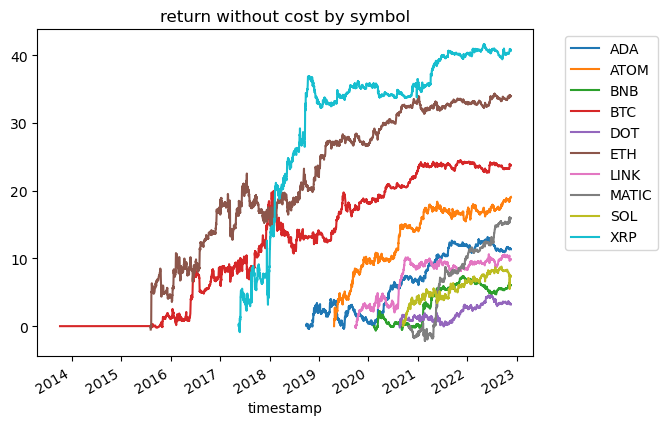

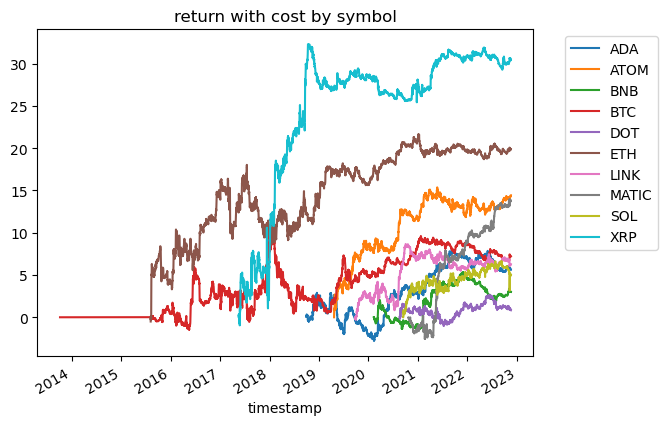

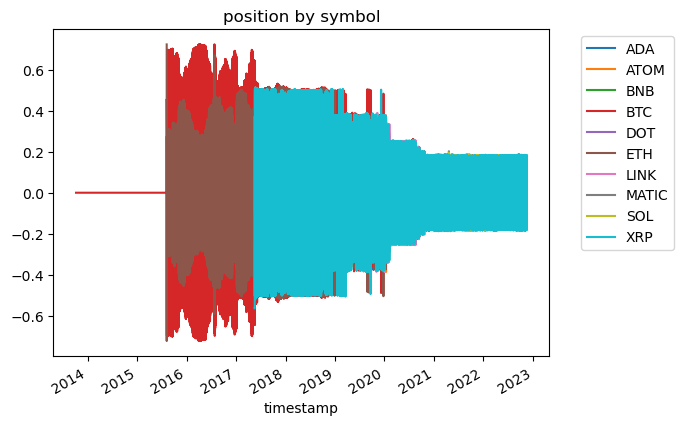

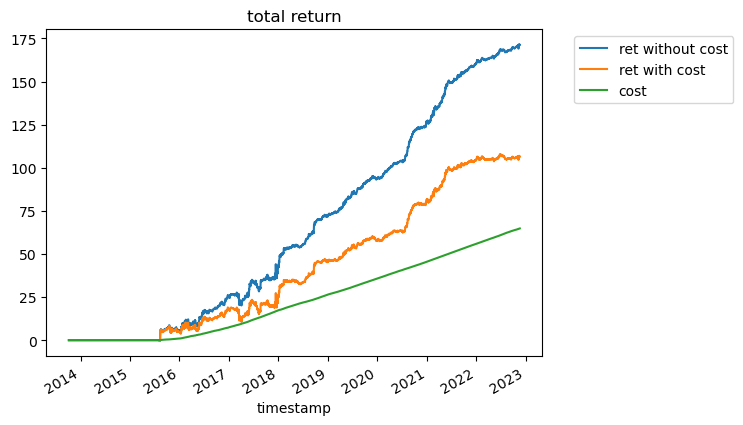

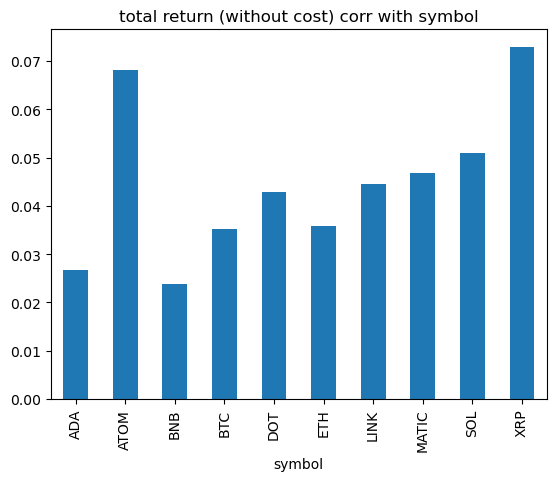

return without cost statistics
mean 0.0028027029091737352
std 0.016550512384450315
sharpe 0.16934236500176003
double sharpe 1.25689107269668
max drawdown 2.497866147690303
min -0.15913774385294924
min sharpe 0.017611804976722333
return with cost statistics
mean 0.0017555241381378359
std 0.016548313476641003
sharpe 0.10608477659163695
double sharpe 0.6300215316224498
max drawdown 3.2322160445502917
min -0.16105626767080855
min sharpe 0.010900067184755858


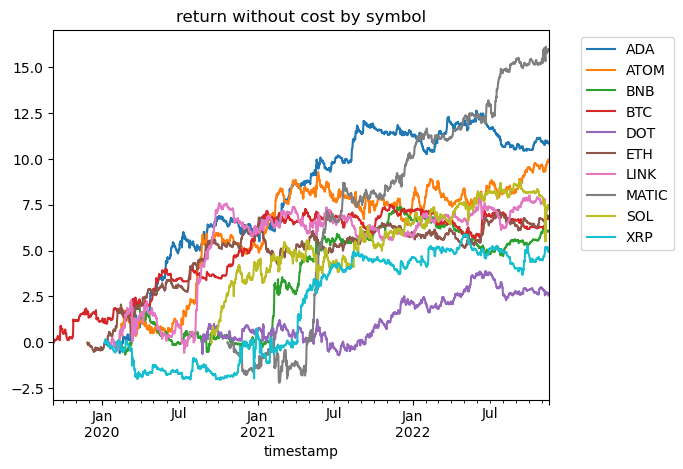

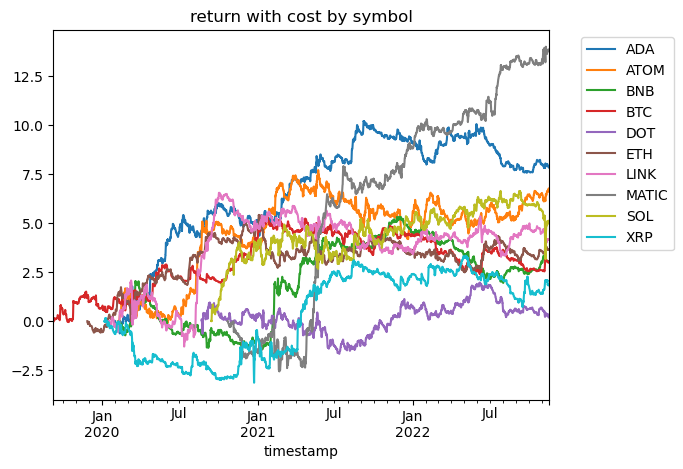

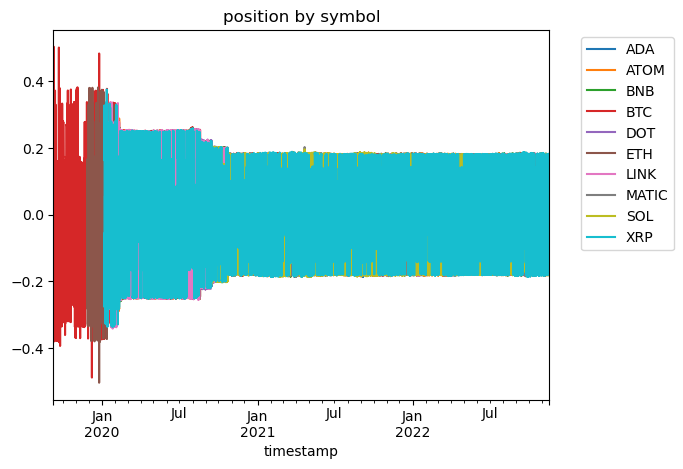

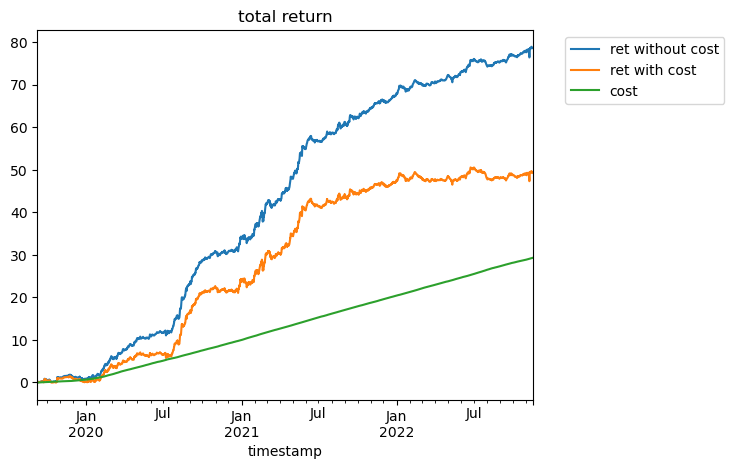

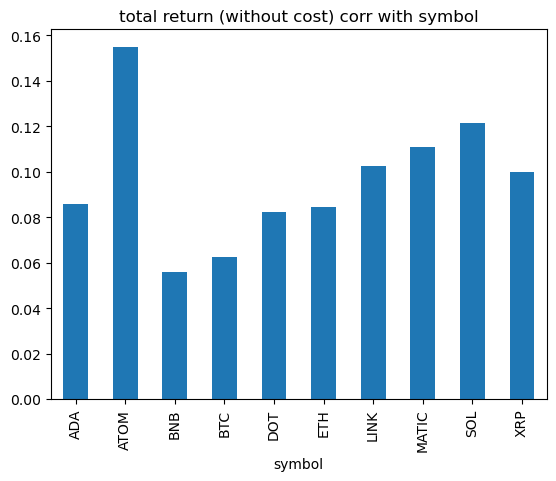

In [5]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-19 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())
visualize_result(df.loc[~df['extended']].dropna())
# visualize_result(df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2019-08-01 00:00:00Z')].dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220907_beta.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-09-20 18:00:00+00:00  ADA       0.000000
                           ATOM      0.000000
                           BNB       0.000000
                           BTC       0.000000
                           DOT       0.000000
                                       ...   
2022-11-19 18:00:00+00:00  ETH       0.021209
                           LINK     -0.018791
                           MATIC    -0.098791
                           SOL      -0.058791
                           XRP       0.181209
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-09-20 19:00:00+00:00 ADA     -0.140000  -0.140000   0.000000
                          ATOM    -0.100000  -0.100000   0.000000
                          BNB      0.180000   0.180000   0.000000
                          BTC     -0.180000  -0.180000   0.000000
                          DOT      0.060000   0.060000   0.000000
...                                     ...        ...        ...
2022-11-19 17:00:00+00:00 ETH      0.021441   0.021441   0.021441
                          LINK    -0.018559  -0.018559  -0.018559
                          MATIC   -0.138559  -0.138559  -0.138559
                          SOL     -0.058559  -0.058559  -0.058559
                          XRP      0.181441   0.181441   0.181441

[14390 rows x 3 columns]

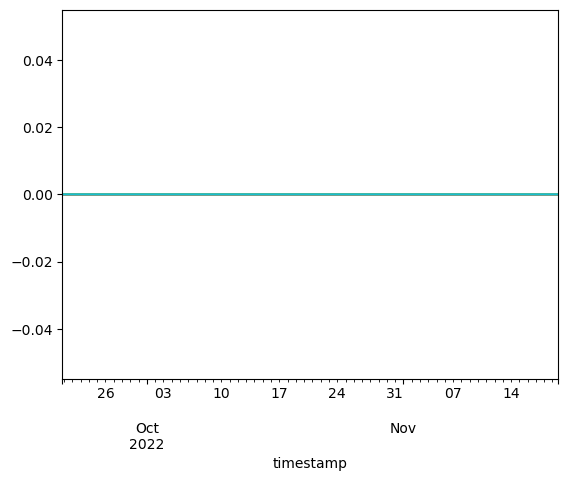

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


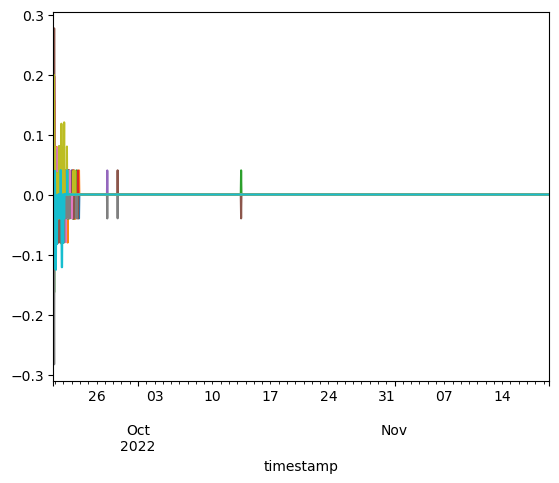

ADA (1441, 3)
ATOM (1441, 3)
BNB (1441, 3)
BTC (1441, 3)
DOT (1441, 3)
ETH (1441, 3)
LINK (1441, 3)
MATIC (1441, 3)
SOL (1441, 3)
XRP (1441, 3)


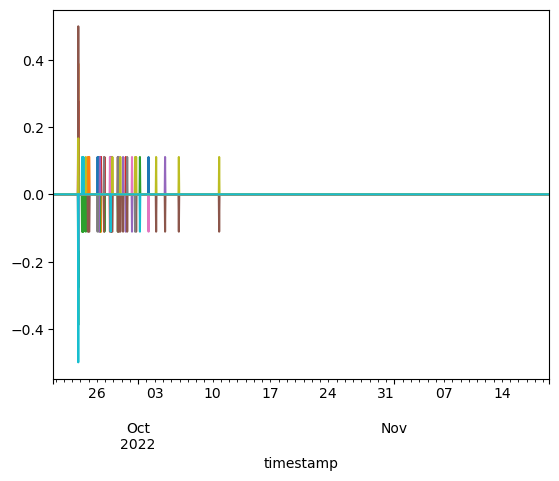

In [6]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220907_beta.xz')
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()